# Benchmarking
benchmarking using [MQTBench](https://mqt.readthedocs.io/projects/bench/en/latest/Quickstart.html) with QFT for 15 qubits

In [97]:
from lib.distributed_coupling_map import build_coupling_list_ring, build_coupling_list_full, build_coupling_list_grid, build_coupling_list_line, build_coupling_list_t_horizontal, build_coupling_list_t_vertical
from lib.interaction_mapping import InteractionMapping
from lib.interaction_layout import InteractionLayout
from lib.lookahead_routing import DynamicLookaheadSwap
from lib.timer_helper import Timer

In [101]:
from qiskit import QuantumCircuit, transpile
from qiskit.transpiler import CouplingMap
from qiskit.transpiler import PassManager, StagedPassManager
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler.preset_passmanagers.common import generate_embed_passmanager, generate_routing_passmanager
from qiskit.providers import Backend
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.converters import circuit_to_dag
from qiskit.visualization import plot_coupling_map, plot_circuit_layout, plot_histogram

In [27]:
from mqt.bench import get_benchmark, CompilerSettings, QiskitSettings

In [28]:
optimization_level = 0
compiler_settings = CompilerSettings(qiskit=QiskitSettings(optimization_level))

In [69]:
benchmark_name = "ghz"
# level = "indep" # but cannot compare because need translation
level = "nativegates"
circuit_size = 5
qc_ghz = get_benchmark(
    benchmark_name=benchmark_name, level=level, circuit_size=circuit_size, 
    compiler="qiskit", compiler_settings=compiler_settings, provider_name="ibm"
)
print(f"Circuit {benchmark_name}[{circuit_size}] -> size: {qc_ghz.size()} depth: {qc_ghz.depth()}")
# display(qc_ghz.draw("mpl"))

Circuit ghz[5] -> size: 12 depth: 8


Transpiled qft[15] -> size: 1080 depth: 332


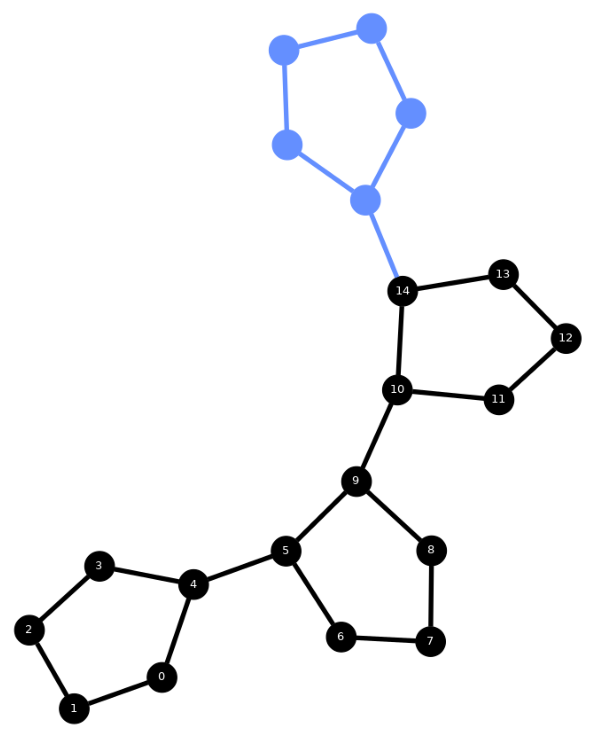

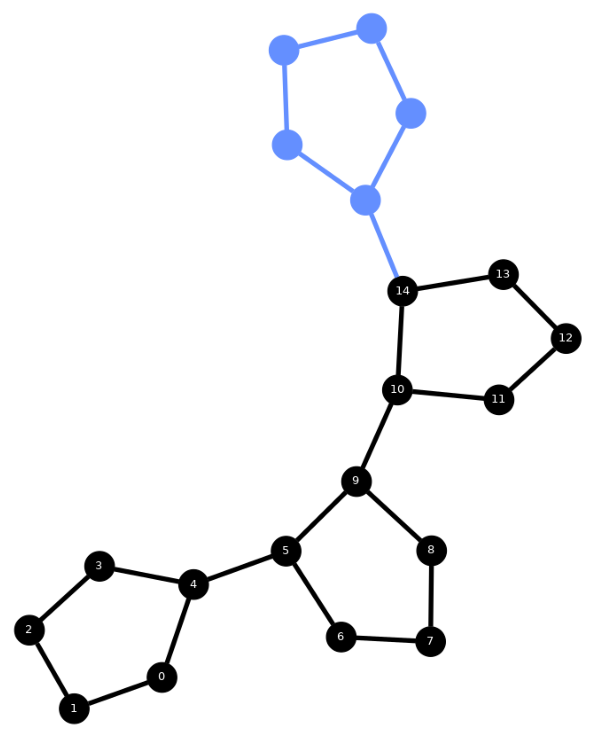

In [30]:
num_qubits = 5
num_group = 4
coupling_list_ring = build_coupling_list_ring(num_qubits, num_group)
coupling_map_ring = CouplingMap(couplinglist=coupling_list_ring)

backend_ring = GenericBackendV2(num_qubits=num_qubits * num_group, coupling_map=coupling_map_ring)
pass_manager = generate_preset_pass_manager(optimization_level, backend=backend_ring)
qc_ghz_isa = pass_manager.run(qc_ghz)
print(f"Transpiled {benchmark_name}[{circuit_size}] -> size: {qc_ghz_isa.size()} depth: {qc_ghz_isa.depth()}")
display(plot_circuit_layout(qc_ghz_isa, backend_ring, view='physical'))
display(plot_circuit_layout(qc_ghz_isa, backend_ring, view='virtual'))

In [32]:
# Define a threshold for significant occurrence
# For example, here we use 10% of the maximum count as the threshold
def get_most_occurence(counts: dict, threshold_index: float = 0.7) -> list:
    threshold = threshold_index * max(counts.values())

    # Filter the keys based on the threshold
    significant_keys = [key for key, value in counts.items() if value > threshold]
    return significant_keys

In [ ]:
job_ring = backend_ring.run(qc_ghz_isa)
counts_ring = job_ring.result().get_counts()
sig_ring_counts = get_most_occurence(counts_ring, 0.7)
sig_ring_counts.sort()

In [35]:
print(sig_ring_counts, "\n", len(sig_ring_counts))

['000001011011100', '000001101000011', '000010010110110', '000011010010000', '000011011101001', '000101000011100', '010000010100000', '010100011000000', '010110001100101', '011100100010100', '100010001100001', '100011011000001', '100100011000000', '101000000010010', '101000011000011', '111001011001000'] 
 16


In [93]:
# use dictionary to save the result
benchmark_name_list = [
    "ae",
    "dj",
    # "grover-noancilla", # '[5] grover-noancilla': {'size': 720, 'depth': 453, 'interval': 0.13467860221862793}
    # "grover-v-chain", # '[5] grover-v-chain': {'size': 750, 'depth': 464, 'interval': 0.11993575096130371}
    "ghz",
    "graphstate",
    "portfolioqaoa",
    "portfoliovqe",
    "qaoa",
    "qft",
    "qftentangled",
    "qnn",
    "qpeexact",
    "qpeinexact",
    # "qwalk-noancilla", # '[5] qwalk-noancilla': {'size': 1310, 'depth': 915, 'interval': 0.07286214828491211}
    # "qwalk-v-chain", # '[5] qwalk-v-chain': {'size': 856, 'depth': 583, 'interval': 0.022635459899902344}
    "random",
    "realamprandom",
    "su2random",
    "twolocalrandom",
    "vqe",
    "wstate",
    
    # non-scalable benchmarks
    
    # "shor", # benchmark_instance_name must be defined for this benchmark.
    # "pricingcall", # Benchmark pricingcall[5] -> size: 901 depth: 568 interval: 0.18169641494750977
    # "pricingput", # Benchmark pricingput[5] -> size: 931 depth: 568 interval: 0.1800365447998047
    # "groundstate", # benchmark_instance_name must be defined for this benchmark.
    # "routing",
    # "tsp",
]
circuit_size_list = [5, 10, 15]

def init_dict_benchmark(circuit_size_list, benchmark_name_list, dict_benchmark):
    for circuit_size in circuit_size_list:
        if circuit_size not in dict_benchmark: # circuit size level
            dict_benchmark[circuit_size] = {}
            for benchmark_name in benchmark_name_list:
                if benchmark_name not in dict_benchmark[circuit_size]: # benchmark name level
                    dict_benchmark[circuit_size][benchmark_name] = {}
                    if 'init' not in dict_benchmark[circuit_size][benchmark_name]: # coupling map level
                        dict_benchmark[circuit_size][benchmark_name]['init'] = {}
    return dict_benchmark

In [94]:
dict_benchmark = {} # level: circuit_size -> benchmark_name -> coupling_map, ex: ['init'], ['ring_5_4'], ['line_5_4'] -> ['size'], ['swap'], ['depth' (optional)], ['interval']

# line, full, ring_10_2, ring_5_4, grid_3_3_2, grid_3_2_3, t_horizontal_4, t_vertical_4

# provide around 20 num_qubits in total
dict_benchmark = init_dict_benchmark(circuit_size_list, benchmark_name_list, dict_benchmark)
print(dict_benchmark)

{5: {'ae': {'init': {}}, 'dj': {'init': {}}, 'ghz': {'init': {}}, 'graphstate': {'init': {}}, 'portfolioqaoa': {'init': {}}, 'portfoliovqe': {'init': {}}, 'qaoa': {'init': {}}, 'qft': {'init': {}}, 'qftentangled': {'init': {}}, 'qnn': {'init': {}}, 'qpeexact': {'init': {}}, 'qpeinexact': {'init': {}}, 'random': {'init': {}}, 'realamprandom': {'init': {}}, 'su2random': {'init': {}}, 'twolocalrandom': {'init': {}}, 'vqe': {'init': {}}, 'wstate': {'init': {}}}, 10: {'ae': {'init': {}}, 'dj': {'init': {}}, 'ghz': {'init': {}}, 'graphstate': {'init': {}}, 'portfolioqaoa': {'init': {}}, 'portfoliovqe': {'init': {}}, 'qaoa': {'init': {}}, 'qft': {'init': {}}, 'qftentangled': {'init': {}}, 'qnn': {'init': {}}, 'qpeexact': {'init': {}}, 'qpeinexact': {'init': {}}, 'random': {'init': {}}, 'realamprandom': {'init': {}}, 'su2random': {'init': {}}, 'twolocalrandom': {'init': {}}, 'vqe': {'init': {}}, 'wstate': {'init': {}}}, 15: {'ae': {'init': {}}, 'dj': {'init': {}}, 'ghz': {'init': {}}, 'graphst

In [95]:
def start_initial_benchmark(benchmark_name: str, circuit_size: int, dict_benchmark: dict):
    level = "nativegates"
    optimization_level = 0
    compiler_settings = CompilerSettings(qiskit=QiskitSettings(optimization_level))
    with Timer() as t:
        qc = get_benchmark(
        benchmark_name=benchmark_name, level=level, circuit_size=circuit_size, 
        compiler="qiskit", compiler_settings=compiler_settings, provider_name="ibm"
        )
    dict_benchmark[circuit_size][benchmark_name]['init']['size'] = qc.size()
    dict_benchmark[circuit_size][benchmark_name]['init']['depth'] = qc.depth()
    dict_benchmark[circuit_size][benchmark_name]['init']['interval'] = t.interval
    return qc

# if want to change interval in ms = t.interval*10**3

In [99]:
def build_generic_backend(
    layout_name: str, num_qubits: int, num_group: int, num_rows = None, num_cols = None # num_rows and num_cols only used in grid
) ->  GenericBackendV2:
    if layout_name == "full":
        couplinglist = build_coupling_list_full(num_qubits)
    elif layout_name == "line":
        couplinglist = build_coupling_list_line(num_qubits, num_group)
    elif layout_name == "ring":
        couplinglist = build_coupling_list_ring(num_qubits, num_group)
    elif layout_name == "grid":
        couplinglist = build_coupling_list_grid(
            num_rows=num_rows if num_rows is not None else num_qubits,
            num_columns=num_cols if num_cols is not None else num_qubits,
            num_group=num_group,
        )
    elif layout_name == "t_horizontal":
        couplinglist = build_coupling_list_t_horizontal(num_group)
    elif layout_name == "t_vertical":
        couplinglist = build_coupling_list_t_vertical(num_group)
    else:
        raise Exception(f"Layout name: {layout_name} is not supported yet.")

    gen_backend = GenericBackendV2(num_qubits=num_qubits * num_group, coupling_map=couplinglist) # can directly add coupling list without casting to CouplingMap
    return gen_backend

In [102]:
def build_pass_manager(swap_name: str, backend: Backend, best_layout = None) -> PassManager:
    if swap_name == 'lookahead':
        pass_manager = StagedPassManager()
        pass_manager.layout = PassManager(InteractionLayout(coupling_map=backend.coupling_map, initial_map=best_layout))
        pass_manager.layout += generate_embed_passmanager(backend.coupling_map)
        pass_manager.routing = PassManager(DynamicLookaheadSwap(backend.coupling_map))
    elif swap_name == 'sabre':
        pass_manager = generate_preset_pass_manager(optimization_level=0, backend=backend, layout_method='sabre', routing_method='sabre')
    elif swap_name == 'basic':
        pass_manager = generate_preset_pass_manager(optimization_level=0, backend=backend, layout_method='trivial', routing_method='basic')
    else:
        raise Exception(f"Swap technique {swap_name} is not available yet.")
    return pass_manager

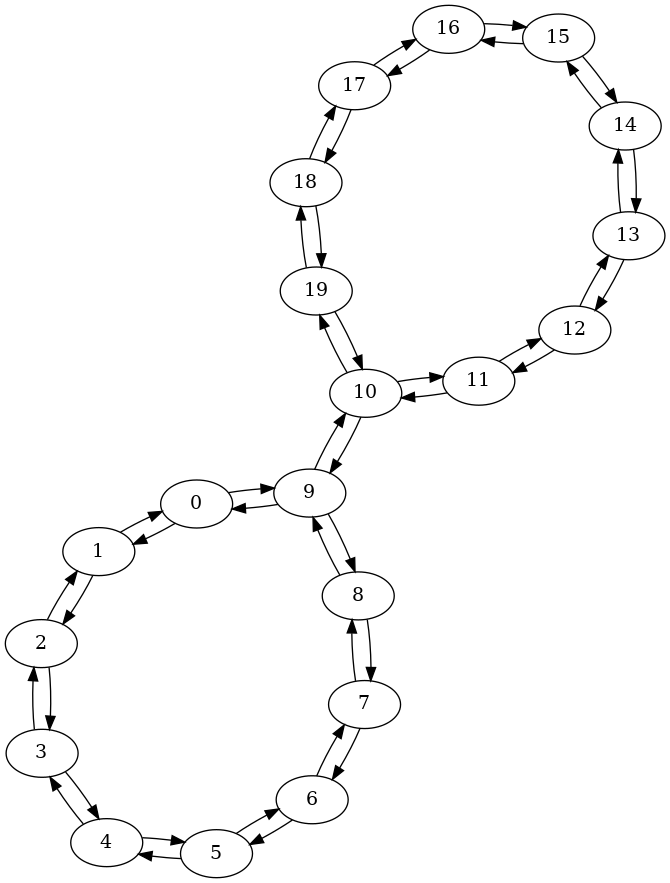

In [100]:
gen_ring = build_generic_backend(layout_name='ring', num_qubits=10, num_group=2)
display(gen_ring.coupling_map.draw())

In [89]:
with Timer() as t:
    # for circuit_size in circuit_size_list:
    for benchmark_name in benchmark_name_list:
        qc = start_initial_benchmark(benchmark_name=benchmark_name, circuit_size=5, dict_benchmark=dict_benchmark)
        

print("Circuit size: 5 with time:", t.interval)

# Circuit size: 5 with time: 6.1507463455200195 (6.1s)

Circuit size: 5 with time: 5.052213191986084


In [90]:
with Timer() as t:
    # for circuit_size in circuit_size_list:
    for benchmark_name in benchmark_name_list:
        start_initial_benchmark(benchmark_name=benchmark_name, circuit_size=10, dict_benchmark=dict_benchmark)

print("Circuit size: 10 with time:", t.interval)

# Circuit size: 10 with time: 28.9819118976593 (28.9s)

Circuit size: 10 with time: 19.171707153320312


In [91]:
with Timer() as t:
    # for circuit_size in circuit_size_list:
    for benchmark_name in benchmark_name_list:
        start_initial_benchmark(benchmark_name=benchmark_name, circuit_size=15, dict_benchmark=dict_benchmark)

print("Circuit size: 15 with time:", t.interval)

# Circuit size: 15 with time: 718.7938868999481 (11m 58.7s)

KeyboardInterrupt: 

In [88]:
# for circuit_size in circuit_size_list:
#     for benchmark_name in benchmark_name_list:
#         with Timer() as t:
#             start_initial_benchmark(benchmark_name=benchmark_name, circuit_size=circuit_size, dict_benchmark=dict_benchmark)
#     print(f"Circuit [{circuit_size}]: {t.interval}")

# print(dict_benchmark)

# Circuit [5]: 0.006738901138305664
# Circuit [10]: 0.009879827499389648
# Circuit [15]: 0.03544354438781738
# Timeout for circuit with num_qubits = 20

In [ ]:
for size, benchmark in dict_benchmark.items():
    for name, qc in dict_benchmark[size].items():
        print(f"Benchmark {name}[{size}] -> size: {dict_benchmark[size][name]['size']} depth: {dict_benchmark[size][name]['depth']} interval: {dict_benchmark[size][name]['interval']}")

In [83]:
print(dict_benchmark)

{5: {'ae': {'size': 120, 'depth': 78, 'interval': 0.02740001678466797}, 'dj': {'size': 40, 'depth': 12, 'interval': 0.004911899566650391}, 'ghz': {'size': 12, 'depth': 8, 'interval': 0.003868579864501953}, 'graphstate': {'size': 55, 'depth': 23, 'interval': 0.015009880065917969}, 'portfolioqaoa': {'size': 205, 'depth': 74, 'interval': 1.6542315483093262}, 'portfoliovqe': {'size': 315, 'depth': 108, 'interval': 0.14344382286071777}, 'qaoa': {'size': 100, 'depth': 32, 'interval': 2.3502464294433594}, 'qft': {'size': 76, 'depth': 39, 'interval': 0.008972883224487305}, 'qftentangled': {'size': 83, 'depth': 43, 'interval': 0.009781837463378906}, 'qnn': {'size': 159, 'depth': 59, 'interval': 0.02324962615966797}, 'qpeexact': {'size': 85, 'depth': 48, 'interval': 0.009783267974853516}, 'qpeinexact': {'size': 85, 'depth': 48, 'interval': 0.009353160858154297}, 'random': {'size': 228, 'depth': 98, 'interval': 0.04326272010803223}, 'realamprandom': {'size': 135, 'depth': 38, 'interval': 0.010931

NOT USED

{5: {'ae': {'size': 120, 'depth': 78, 'interval': 0.06123471260070801}, 'dj': {'size': 40, 'depth': 12, 'interval': 0.005676984786987305}, 'grover-noancilla': {'size': 720, 'depth': 453, 'interval': 0.13467860221862793}, 'grover-v-chain': {'size': 750, 'depth': 464, 'interval': 0.11993575096130371}, 'ghz': {'size': 12, 'depth': 8, 'interval': 0.0029976367950439453}, 'graphstate': {'size': 55, 'depth': 23, 'interval': 0.0066680908203125}, 'portfolioqaoa': {'size': 205, 'depth': 74, 'interval': 1.6511530876159668}, 'portfoliovqe': {'size': 315, 'depth': 108, 'interval': 0.1276383399963379}, 'qaoa': {'size': 100, 'depth': 32, 'interval': 3.15156888961792}, 'qft': {'size': 76, 'depth': 39, 'interval': 0.008755207061767578}, 'qftentangled': {'size': 83, 'depth': 43, 'interval': 0.009991884231567383}, 'qnn': {'size': 159, 'depth': 59, 'interval': 0.021454572677612305}, 'qpeexact': {'size': 85, 'depth': 48, 'interval': 0.009104490280151367}, 'qpeinexact': {'size': 85, 'depth': 48, 'interval': 0.009027719497680664}, 'qwalk-noancilla': {'size': 1310, 'depth': 915, 'interval': 0.07286214828491211}, 'qwalk-v-chain': {'size': 856, 'depth': 583, 'interval': 0.022635459899902344}, 'random': {'size': 228, 'depth': 98, 'interval': 0.04922366142272949}, 'realamprandom': {'size': 135, 'depth': 38, 'interval': 0.011357545852661133}, 'su2random': {'size': 155, 'depth': 42, 'interval': 0.01523900032043457}, 'twolocalrandom': {'size': 135, 'depth': 38, 'interval': 0.011612892150878906}, 'vqe': {'size': 88, 'depth': 22, 'interval': 0.626173734664917}, 'wstate': {'size': 78, 'depth': 46, 'interval': 0.00664067268371582}}, 

10: {'ae': {'size': 375, 'depth': 183, 'interval': 0.06368637084960938}, 'dj': {'size': 88, 'depth': 18, 'interval': 0.005908489227294922}, 'grover-noancilla': {'size': 56393, 'depth': 41804, 'interval': 5.6616294384002686}, 'grover-v-chain': {'size': 33278, 'depth': 23972, 'interval': 3.9432711601257324}, 'ghz': {'size': 22, 'depth': 13, 'interval': 0.003917217254638672}, 'graphstate': {'size': 110, 'depth': 23, 'interval': 0.01208639144897461}, 'portfolioqaoa': {'size': 635, 'depth': 134, 'interval': 7.0105180740356445}, 'portfoliovqe': {'size': 1155, 'depth': 218, 'interval': 0.3509335517883301}, 'qaoa': {'size': 200, 'depth': 35, 'interval': 5.980944633483887}, 'qft': {'size': 280, 'depth': 79, 'interval': 0.020592927932739258}, 'qftentangled': {'size': 292, 'depth': 83, 'interval': 0.019933223724365234}, 'qnn': {'size': 469, 'depth': 109, 'interval': 0.05214190483093262}, 'qpeexact': {'size': 291, 'depth': 94, 'interval': 0.02092909812927246}, 'qpeinexact': {'size': 301, 'depth': 108, 'interval': 0.019690990447998047}, 'qwalk-noancilla': {'size': 37027, 'depth': 30375, 'interval': 1.930440902709961}, 'qwalk-v-chain': {'size': 5366, 'depth': 3823, 'interval': 0.08152532577514648}, 'random': {'size': 656, 'depth': 156, 'interval': 0.08172965049743652}, 'realamprandom': {'size': 345, 'depth': 58, 'interval': 0.01710343360900879}, 'su2random': {'size': 385, 'depth': 62, 'interval': 0.020605087280273438}, 'twolocalrandom': {'size': 345, 'depth': 58, 'interval': 0.016749858856201172}, 'vqe': {'size': 178, 'depth': 27, 'interval': 3.279741048812866}, 'wstate': {'size': 173, 'depth': 91, 'interval': 0.00919342041015625}}, 

15: {'ae': {'size': 755, 'depth': 288, 'interval': 0.11601424217224121}, 'dj': {'size': 132, 'depth': 23, 'interval': 0.008326292037963867}, 'grover-noancilla': {'size': 5497658, 'depth': 4477223, 'interval': 325.69741678237915}, 'grover-v-chain': {'size': 613068, 'depth': 458002, 'interval': 60.66740345954895}, 'ghz': {'size': 32, 'depth': 18, 'interval': 0.058370113372802734}, 'graphstate': {'size': 165, 'depth': 32, 'interval': 0.009457588195800781}, 'portfolioqaoa': {'size': 1290, 'depth': 194, 'interval': 55.535638093948364}, 'portfoliovqe': {'size': 2520, 'depth': 328, 'interval': 4.045258045196533}, 'qaoa': {'size': 300, 'depth': 35, 'interval': 155.33658266067505}, 'qft': {'size': 606, 'depth': 119, 'interval': 0.035943031311035156}, 'qftentangled': {'size': 623, 'depth': 123, 'interval': 0.03734445571899414}, 'qnn': {'size': 929, 'depth': 159, 'interval': 0.09948515892028809}, 'qpeexact': {'size': 645, 'depth': 168, 'interval': 0.03950214385986328}, 'qpeinexact': {'size': 645, 'depth': 168, 'interval': 0.04153585433959961}, 'qwalk-noancilla': {'size': 1179816, 'depth': 982395, 'interval': 60.82111620903015}, 'qwalk-v-chain': {'size': 13776, 'depth': 9763, 'interval': 0.2902679443359375}, 'random': {'size': 2007, 'depth': 413, 'interval': 0.15323758125305176}, 'realamprandom': {'size': 630, 'depth': 78, 'interval': 0.027808666229248047}, 'su2random': {'size': 690, 'depth': 82, 'interval': 0.03222966194152832}, 'twolocalrandom': {'size': 630, 'depth': 78, 'interval': 0.027130842208862305}, 'vqe': {'size': 268, 'depth': 32, 'interval': 35.94181728363037}, 'wstate': {'size': 268, 'depth': 136, 'interval': 0.02783370018005371}}}


Final result with num_qubits between 5, 10, 15 because num_qubits = 20 yields >30mins
{
    5: {'ae': {'size': 120, 'depth': 78, 'interval': 0.02740001678466797}, 'dj': {'size': 40, 'depth': 12, 'interval': 0.004911899566650391}, 'ghz': {'size': 12, 'depth': 8, 'interval': 0.003868579864501953}, 'graphstate': {'size': 55, 'depth': 23, 'interval': 0.015009880065917969}, 'portfolioqaoa': {'size': 205, 'depth': 74, 'interval': 1.6542315483093262}, 'portfoliovqe': {'size': 315, 'depth': 108, 'interval': 0.14344382286071777}, 'qaoa': {'size': 100, 'depth': 32, 'interval': 2.3502464294433594}, 'qft': {'size': 76, 'depth': 39, 'interval': 0.008972883224487305}, 'qftentangled': {'size': 83, 'depth': 43, 'interval': 0.009781837463378906}, 'qnn': {'size': 159, 'depth': 59, 'interval': 0.02324962615966797}, 'qpeexact': {'size': 85, 'depth': 48, 'interval': 0.009783267974853516}, 'qpeinexact': {'size': 85, 'depth': 48, 'interval': 0.009353160858154297}, 'random': {'size': 228, 'depth': 98, 'interval': 0.04326272010803223}, 'realamprandom': {'size': 135, 'depth': 38, 'interval': 0.010931730270385742}, 'su2random': {'size': 155, 'depth': 42, 'interval': 0.012021780014038086}, 'twolocalrandom': {'size': 135, 'depth': 38, 'interval': 0.00968623161315918}, 'vqe': {'size': 88, 'depth': 22, 'interval': 0.6425080299377441}, 'wstate': {'size': 78, 'depth': 46, 'interval': 0.006522655487060547}}, 
    
    10: {'ae': {'size': 375, 'depth': 183, 'interval': 0.04560279846191406}, 'dj': {'size': 88, 'depth': 18, 'interval': 0.006821155548095703}, 'ghz': {'size': 22, 'depth': 13, 'interval': 0.003332853317260742}, 'graphstate': {'size': 110, 'depth': 23, 'interval': 0.0077779293060302734}, 'portfolioqaoa': {'size': 635, 'depth': 134, 'interval': 7.246534585952759}, 'portfoliovqe': {'size': 1155, 'depth': 218, 'interval': 0.36896371841430664}, 'qaoa': {'size': 200, 'depth': 35, 'interval': 4.92164945602417}, 'qft': {'size': 280, 'depth': 79, 'interval': 0.020704269409179688}, 'qftentangled': {'size': 292, 'depth': 83, 'interval': 0.020392894744873047}, 'qnn': {'size': 469, 'depth': 109, 'interval': 0.051140546798706055}, 'qpeexact': {'size': 291, 'depth': 94, 'interval': 0.019837141036987305}, 'qpeinexact': {'size': 301, 'depth': 108, 'interval': 0.020482301712036133}, 'random': {'size': 656, 'depth': 156, 'interval': 0.07756686210632324}, 'realamprandom': {'size': 345, 'depth': 58, 'interval': 0.016701459884643555}, 'su2random': {'size': 385, 'depth': 62, 'interval': 0.020280122756958008}, 'twolocalrandom': {'size': 345, 'depth': 58, 'interval': 0.016274213790893555}, 'vqe': {'size': 178, 'depth': 27, 'interval': 3.253117084503174}, 'wstate': {'size': 173, 'depth': 91, 'interval': 0.00943613052368164}}, 
    
    15: {'ae': {'size': 755, 'depth': 288, 'interval': 0.09475922584533691}, 'dj': {'size': 132, 'depth': 23, 'interval': 0.012288331985473633}, 'ghz': {'size': 32, 'depth': 18, 'interval': 0.0038166046142578125}, 'graphstate': {'size': 165, 'depth': 32, 'interval': 0.012863636016845703}, 'portfolioqaoa': {'size': 1290, 'depth': 194, 'interval': 55.74790978431702}, 'portfoliovqe': {'size': 2520, 'depth': 328, 'interval': 4.114985227584839}, 'qaoa': {'size': 300, 'depth': 35, 'interval': 74.61874294281006}, 'qft': {'size': 606, 'depth': 119, 'interval': 0.037769317626953125}, 'qftentangled': {'size': 623, 'depth': 123, 'interval': 0.0379338264465332}, 'qnn': {'size': 929, 'depth': 159, 'interval': 0.10702061653137207}, 'qpeexact': {'size': 645, 'depth': 168, 'interval': 0.043341636657714844}, 'qpeinexact': {'size': 645, 'depth': 168, 'interval': 0.03839826583862305}, 'random': {'size': 2007, 'depth': 413, 'interval': 0.15143346786499023}, 'realamprandom': {'size': 630, 'depth': 78, 'interval': 0.025641918182373047}, 'su2random': {'size': 690, 'depth': 82, 'interval': 0.03173208236694336}, 'twolocalrandom': {'size': 630, 'depth': 78, 'interval': 0.026518583297729492}, 'vqe': {'size': 268, 'depth': 32, 'interval': 35.26623058319092}, 'wstate': {'size': 268, 'depth': 136, 'interval': 0.033203125}}, 
    
    20: {'ae': {'size': 1260, 'depth': 393, 'interval': 0.12457704544067383}, 'dj': {'size': 176, 'depth': 28, 'interval': 0.008887290954589844}, 'ghz': {'size': 42, 'depth': 23, 'interval': 0.00421142578125}, 'graphstate': {'size': 220, 'depth': 22, 'interval': 0.011346817016601562}, 'portfolioqaoa': {}, 'portfoliovqe': {}, 'qaoa': {}, 'qft': {}, 'qftentangled': {}, 'qnn': {}, 'qpeexact': {}, 'qpeinexact': {}, 'random': {}, 'realamprandom': {}, 'su2random': {}, 'twolocalrandom': {}, 'vqe': {}, 'wstate': {}}
    
    }
